In [1]:
import os

import pymoocdb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Dataset

- Performance of EPFL Students on the courses 

- 6562 students
- 37 courses
- 7 semesters
- 17490 grades

In [2]:
SQLQuery = """
SELECT DISTINCT
    EPFL_HashedSciper, 
    EPFL_CourseID, 
    EPFL_ExamDate, 
    EPFL_EPFLCourseGrade 
FROM semester_projects.epfl_and_mooc_grades
LIMIT 100000;
"""

db = pymoocdb.MoocDBLink()
db.ExecuteQuery(SQLQuery)
db.close()

data = pd.DataFrame(
    data=db.GetReturnedRows(), 
    columns=['StudentID', 'CourseID', 'ExamDate', 'Grade']
)
data.Grade = data.Grade.apply(pd.to_numeric, errors='coerce')
data.ExamDate = data.ExamDate.apply(pd.to_datetime)
data.CourseID = data.CourseID.apply(lambda x: x.split('(')[0])
data = data[data.CourseID != 'CS-522']
data.dropna(axis=0, inplace=True)

def z(obj, key):
    if key not in obj: 
        obj[key] = len(obj)
    return obj[key]

_students = {}
_courses = {}

data.StudentID = data.StudentID.apply(lambda x: z(_students, x))
data.CourseID = data.CourseID.apply(lambda x: z(_courses, x))

courses = {v: k for k,v in _courses.items()}

data['Result'] = data.Grade.apply(lambda grade: 1 if grade > 3.9 else 0)

data.sort_values(by='ExamDate', inplace=True)
data.reset_index(drop=True, inplace=True)
data.head(10)

,StudentID,CourseID,ExamDate,Grade,Result
0,6542,20,2013-07-01,6.0,1
1,1280,14,2013-07-01,6.0,1
2,1279,14,2013-07-01,4.0,1
3,1278,14,2013-07-01,5.0,1
4,1277,14,2013-07-01,5.0,1
5,1276,14,2013-07-01,4.5,1
6,1275,14,2013-07-01,3.5,0
7,1274,14,2013-07-01,3.0,0
8,1273,14,2013-07-01,4.5,1
9,1272,14,2013-07-01,3.0,0


## Analysis

The grades follow a nice smooth distribution with median of 4 which is also the passing grade

count    17471.000000
mean         4.034028
std          1.168368
min          1.000000
25%          3.500000
50%          4.000000
75%          5.000000
max          6.000000
Name: Grade, dtype: float64

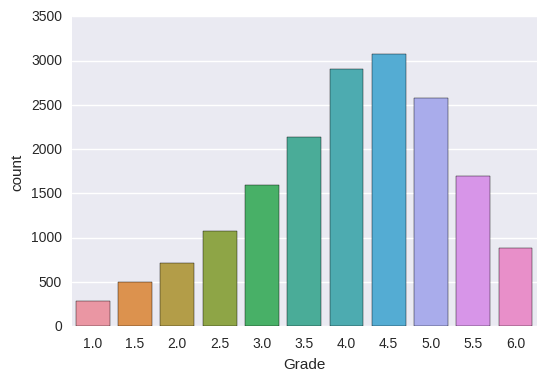

In [ ]:
sns.countplot(x='Grade', data=data)
data.Grade.describe()

# Fitting the LFA model

In [ ]:
from model import *

subset = { 'EE-100', 'EE-102', 'PHYS-101', 'PHYS-106', 'MATH-111', 'MATH-150', 'CS-112', 'CIVIL-123', 'CS-111', 'CIVIL-122', 'ENV-140',  }
s = len(subset)

model = ModelLFA()
model.fit(data[['StudentID', 'CourseID', 'ExamDate', 'Result']].values)

In [ ]:
r = 5
def pos(n={ 'n': 0 }):
    x = math.cos(((math.pi * 2) / s) * n['n']) * r
    y = math.sin(((math.pi * 2) / s) * n['n']) * r
    n['n'] += 1
    return '\"' + str(x) + ',' + str(y) + '!\"'

NODE_SIZE_SCALE = lambda x: max(5e-2 * (x ** 0.5), 1e0)
THICKNESS_SCALE = lambda x: 1e-2 * x

G = nx.DiGraph()

G.add_nodes_from([ (courses[a.id], { 
    'fixedsize': 'true',
    'pos': pos(),
    'width': NODE_SIZE_SCALE(len(a.events)),
    'shape': 'circle',
    'fillcolor': 'yellow',
    'penwidth': 3,
    'style': 'filled'
}) for a in model.activities.values() if courses[a.id] in subset ])

for a in model.activities.values():
    if courses[a.id] in subset:
        for b in a.activityList:
            if courses[b] in subset:
                t = THICKNESS_SCALE(a.activityListC[b])
                if a.activityListC[b] > 50:
                    G.add_edge(courses[b], courses[a.id], {
                        'penwidth': t
                    })

nx.drawing.nx_pydot.write_dot(G,'G1.dot')
os.system('neato -Tpng G1.dot -o G1.png')

In [ ]:
def pos(n={ 'n': 0 }):
    x = math.cos(((math.pi * 2) / s) * n['n']) * r
    y = math.sin(((math.pi * 2) / s) * n['n']) * r
    n['n'] += 1
    return '\"' + str(x) + ',' + str(y) + '!\"'

NODE_SIZE_SCALE = lambda x: max(5e-2 * (x ** 0.5), 1e0)
THICKNESS_SCALE = lambda x: max(25e-1 * x, 0)

G = nx.DiGraph(overlap='false')

G.add_nodes_from([ (courses[a.id], { 
    'fixedsize': 'true',
    'pos': pos(),
    'width': NODE_SIZE_SCALE(len(a.events)),
    'shape': 'circle',
    'fillcolor': 'red',
    'penwidth': 3,
    'style': 'filled'
}) for a in model.activities.values() if courses[a.id] in subset ])

for a in model.activities.values():
    if courses[a.id] in subset:
        for i, b in enumerate(a.activityList):
            if courses[b] in subset:
                t = THICKNESS_SCALE(a.params[i])
                if t > 0.5 and a.activityListC[b] > 50:
                    G.add_edge(courses[b], courses[a.id], {
                        'penwidth': t
                    })

nx.drawing.nx_pydot.write_dot(G,'G2.dot')
os.system('neato -Tpng G2.dot -o G2.png')